# Sentiment Analysis of COVID-19 Vaccine Tweets

![vaccine](media/vaccine_cover.jpeg)

![kaggle_preview](media/kaggle_preview.png)

In [1]:
##################################################################################
#       author:     Sejal Dua                                                    #
#         date:     03/15/2021                                                   #
#  data source:     https://www.kaggle.com/gpreda/all-covid19-vaccines-tweets    #
#      credits:     Ariwan Sri Setya, Tom Whelan, Gabriel Preda                  #
##################################################################################

## Data Access

In [3]:
# installs
!pip install textblob
!pip install wordcloud
!python -m textblob.download_corpora
!pip install plotly
!pip install wordninja
!pip install pyspellchecker

You should consider upgrading via the '/Users/sejaldua/miniconda3/bin/python -m pip install --upgrade pip' command.
Processing /Users/sejaldua/Library/Caches/pip/wheels/f8/f6/55/6bd394c32a844a621ca0fe5dbf563c8d71d71edaf095656991/wordcloud-1.8.1-cp37-cp37m-macosx_10_9_x86_64.whl
You should consider upgrading via the '/Users/sejaldua/miniconda3/bin/python -m pip install --upgrade pip' command.


In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud
import plotly.express as px

/Users/sejaldua/miniconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, defaultdict


In [2]:
df = pd.read_csv("vaccination_all_tweets.csv", quotechar='"', delimiter=',').dropna()
df

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
6,1337851215875608579,Gunther Fehlinger,"Austria, Ukraine and Kosovo",End North Stream 2 now - the pipeline of corru...,2013-06-10 17:49:22,2731,5001,69344,False,2020-12-12 20:06:00,it is a bit sad to claim the fame for success ...,['vaccination'],Twitter Web App,0,4,False
9,1337842295857623042,Ch.Amjad Ali,Islamabad,#ProudPakistani #LovePakArmy #PMIK @insafiansp...,2012-11-12 04:18:12,671,2368,20469,False,2020-12-12 19:30:33,#CovidVaccine \n\nStates will start getting #C...,"['CovidVaccine', 'COVID19Vaccine', 'US', 'paku...",Twitter Web App,0,0,False
10,1337841934170255365,Tamer Yazar,Turkey-Israel,"Im Market Analyst, also Editor... working (fre...",2009-09-17 16:45:16,1302,78,339,False,2020-12-12 19:29:07,"while deaths are closing in on the 300,000 mar...","['PfizerBioNTech', 'Vaccine']",Twitter Web App,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27802,1368226947822653442,Andy The legally and popularly elected Gardener.,Untidied States,merciless infj door slammer.,2019-01-01 23:12:42,93,83,9876,False,2021-03-06 15:48:19,If you want to know how much antivaxx disinfor...,['SputnikV'],Twitter for iPhone,0,1,False
27804,1368224770995675139,🌎 Sarwar 🌐,E,W pirsarwarras,2009-07-01 00:18:11,1685,1439,6268,False,2021-03-06 15:39:40,#BREAKING \n#Venezuela \nVenezuelan President ...,"['BREAKING', 'Venezuela', 'SputnikV']",Twitter Web App,0,2,False
27806,1368224272267829256,Workout Solutions,"Toronto, Canada and Worldwide",George Tsanis – Workout Solutions Health and F...,2010-09-20 17:01:08,1164,172,1358,False,2021-03-06 15:37:41,Moscow Russia everything is open business as u...,['COVID19'],Twitter for iPhone,1,2,False
27807,1368218905353859081,William Owen,"Moscow, Russia",| political | cats | bikes | civil rights | te...,2009-03-16 03:03:13,3962,2594,51923,False,2021-03-06 15:16:21,Of course Black (spits) never mentions #Sputni...,"['SputnikV', 'ForbiddenVaccine']",Twitter Web App,0,0,False


In [3]:
print(df.columns)
print(df.shape)

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],
      dtype='object')
(16180, 16)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16180 entries, 0 to 27808
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                16180 non-null  int64 
 1   user_name         16180 non-null  object
 2   user_location     16180 non-null  object
 3   user_description  16180 non-null  object
 4   user_created      16180 non-null  object
 5   user_followers    16180 non-null  int64 
 6   user_friends      16180 non-null  int64 
 7   user_favourites   16180 non-null  int64 
 8   user_verified     16180 non-null  bool  
 9   date              16180 non-null  object
 10  text              16180 non-null  object
 11  hashtags          16180 non-null  object
 12  source            16180 non-null  object
 13  retweets          16180 non-null  int64 
 14  favorites         16180 non-null  int64 
 15  is_retweet        16180 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 1.9+ MB


# Data Wrangling & Preprocessing

In [5]:
df.drop(columns=['id'], inplace=True)

In [6]:
df = df.drop_duplicates('text')
print(df.shape)

(16170, 15)


In [7]:
# use regular expressions to strip each tweet of mentions, hashtags, retweet information, and links
def clean_tweet_text(text):
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'RT[\s]+', '', text)
    text = re.sub(r'https?:\/\/\S+', '', text)
    text = text.lower()
    return text

# the following line makes use of an apply function-- it will call clean_tweet_text on every element in the 'text' column
df['text'].transform(clean_tweet_text)
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
2,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
6,Gunther Fehlinger,"Austria, Ukraine and Kosovo",End North Stream 2 now - the pipeline of corru...,2013-06-10 17:49:22,2731,5001,69344,False,2020-12-12 20:06:00,it is a bit sad to claim the fame for success ...,['vaccination'],Twitter Web App,0,4,False
9,Ch.Amjad Ali,Islamabad,#ProudPakistani #LovePakArmy #PMIK @insafiansp...,2012-11-12 04:18:12,671,2368,20469,False,2020-12-12 19:30:33,#CovidVaccine \n\nStates will start getting #C...,"['CovidVaccine', 'COVID19Vaccine', 'US', 'paku...",Twitter Web App,0,0,False
10,Tamer Yazar,Turkey-Israel,"Im Market Analyst, also Editor... working (fre...",2009-09-17 16:45:16,1302,78,339,False,2020-12-12 19:29:07,"while deaths are closing in on the 300,000 mar...","['PfizerBioNTech', 'Vaccine']",Twitter Web App,0,0,False


In [8]:
# we do not care about the exact time of each tweet, we just want the date
df['date'] = pd.to_datetime(df['date']).dt.date
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
2,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
6,Gunther Fehlinger,"Austria, Ukraine and Kosovo",End North Stream 2 now - the pipeline of corru...,2013-06-10 17:49:22,2731,5001,69344,False,2020-12-12,it is a bit sad to claim the fame for success ...,['vaccination'],Twitter Web App,0,4,False
9,Ch.Amjad Ali,Islamabad,#ProudPakistani #LovePakArmy #PMIK @insafiansp...,2012-11-12 04:18:12,671,2368,20469,False,2020-12-12,#CovidVaccine \n\nStates will start getting #C...,"['CovidVaccine', 'COVID19Vaccine', 'US', 'paku...",Twitter Web App,0,0,False
10,Tamer Yazar,Turkey-Israel,"Im Market Analyst, also Editor... working (fre...",2009-09-17 16:45:16,1302,78,339,False,2020-12-12,"while deaths are closing in on the 300,000 mar...","['PfizerBioNTech', 'Vaccine']",Twitter Web App,0,0,False


# Exploratory Data Analysis (EDA)

In [9]:
df.describe()

,user_followers,user_friends,user_favourites,retweets,favorites
count,1.617000e+04,16170.000000,16170.000000,16170.000000,16170.000000
mean,1.719752e+05,1518.035931,14619.516079,4.241187,18.428386
std,1.141814e+06,7640.144298,37054.083845,45.617605,246.240119
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,2.180000e+02,170.000000,426.000000,0.000000,0.000000
50%,9.470000e+02,492.500000,2377.000000,0.000000,1.000000
75%,4.284000e+03,1372.750000,11847.250000,1.000000,5.000000
max,1.486666e+07,380428.000000,686342.000000,2360.000000,22815.000000


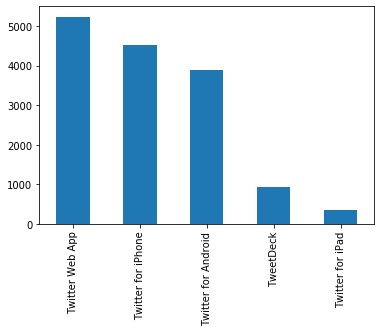

In [17]:
# which device are people tweeting about the vaccine from?
df['source'].value_counts().head(n=5).plot.bar()

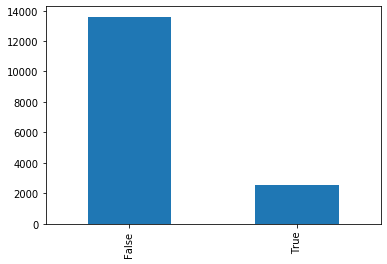

In [14]:
df['user_verified'].value_counts().head(n=10).plot.bar()

In [16]:
df[df['user_verified'] == True].head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
15,City A.M.,"London, England","London's business newspaper - News, Opinion, a...",2009-06-09 13:53:06,66224,603,771,True,2020-12-12,Trump announces #vaccine rollout 'in less than...,['vaccine'],Twitter for iPhone,0,1,False
17,ILKHA,Türkiye,Official Twitter account of Ilke News Agency /,2015-05-22 08:31:12,4056,6,3,True,2020-12-12,"Coronavirus: Iran reports 8,201 new cases, 221...","['Iran', 'coronavirus', 'PfizerBioNTech']",TweetDeck,3,5,False
22,City A.M.,"London, England","London's business newspaper - News, Opinion, a...",2009-06-09 13:53:06,66224,603,771,True,2020-12-12,Trump announces #vaccine rollout 'in less than...,['vaccine'],Buffer,1,0,False
43,City A.M.,"London, England","London's business newspaper - News, Opinion, a...",2009-06-09 13:53:06,66224,603,771,True,2020-12-12,Trump announces #vaccine rollout 'in less than...,['vaccine'],Twitter Web App,0,2,False
44,Daily News Egypt,Egypt,Egypt's Only Daily Independent Newspaper in En...,2009-04-26 07:56:24,278080,116,765,True,2020-12-12,#FDA authorizes #PfizerBioNTech #coronavirus v...,"['FDA', 'PfizerBioNTech', 'coronavirus']",Twitter Web App,1,1,False


In [150]:
# what are the top 10 most retweeted tweets
pd.set_option('display.max_colwidth', 400)
df.sort_values(by='retweets', ascending=False)[['text', 'date', 'user_name', 'user_location', 'hashtags', 'favorites', 'retweets']].head(n=10)

,text,date,user_name,user_location,hashtags,favorites,retweets
17118,"Got my jab. For the curious, it was #Covaxin. \n\nFelt secure, will travel safely. https://t.co/8PL7PZMEsf",2021-03-01,Dr. S. Jaishankar,"New Delhi, India",['Covaxin'],22815,2360
7126,"New research published in Microbiology &amp; Infectious Diseases, immunologist J. Bart Classen warns #mRNA technology u… https://t.co/OWUTf5ShHO",2021-02-10,Robert F. Kennedy Jr,"Los Angles, California",['mRNA'],3090,2247
26737,"#Covaxin 🇮🇳 , made by Hyderabad-based Bharat Biotech International Limited, has been declared ""Safe, Immunogenic wi… https://t.co/FAUOEHJmAw",2021-03-09,Megh Updates 🚨,Turn on Notification 🔔,['Covaxin'],9457,2092
17543,Prime Minister Narendra Modi choose early morning time to take #covaxin . No traffic was stopped . Traveled normall… https://t.co/udxAqk9xEC,2021-03-01,Megh Updates 🚨,Turn on Notification 🔔,['covaxin'],8153,1980
27709,This is not a queue for a Covid vaccine\nThis is a queue at a food bank today in the UK.\n#coronavirus #oxfordvaccine… https://t.co/rGqg14FT9t,2021-03-08,Afshin Rattansi,London,"['coronavirus', 'oxfordvaccine']",1713,1514
20965,#BREAKING : Bharat Biotech says its #Covaxin shows interim clinical efficacy of 81% in Phase 3 results,2021-03-03,Megh Updates 🚨,Turn on Notification 🔔,"['BREAKING', 'Covaxin']",6651,938
20575,It is tough when have to play the sauve Amrikan doctor but ur desi Lahore genes start acting up #Covaxin https://t.co/ZUygPW4WGd,2021-03-03,Manoj Rawat,New Delhi,['Covaxin'],3636,922
13101,AIIMS nurse who gave the #Covaxin jab to Prime Minister @narendramodi speaks to the national broadcaster DD News ab… https://t.co/ivPj4KGiyE,2021-03-01,Aditya Raj Kaul,"New Delhi, India",['Covaxin'],5827,870
21568,"The Opposition campaign to denigrate #Covaxin is disgraceful. So is the refusal by a coterie of senior editors, col… https://t.co/yN6M1BxvCn",2021-03-05,Minhaz Merchant,Mumbai,['Covaxin'],2311,806
20964,Phase 3 Results of #COVAXIN - announced by @BharatBiotech : Demonstrates Interim Clinical Efficacy of 81%,2021-03-03,Prof Shamika Ravi,"New Delhi, Kannauj, Kohima",['COVAXIN'],5575,773


In [20]:
df.sort_values(by=['date', 'favorites'], ascending=[True, False])[['text', 'date', 'user_name', 'user_location', 'hashtags', 'favorites', 'retweets']].head(n=10)

,text,date,user_name,user_location,hashtags,favorites,retweets
35,An immigrant Muslim couple find the COVID-19 V...,2020-12-12,Shahjhan Malik | #WearAMask,"Nottinghamshire, England","['CovidVaccine', 'PfizerBioNTech', 'Pfizervacc...",37,2
293,#UnitedStates : The Federal Aviation Administr...,2020-12-12,DD News,"New Delhi, India",['UnitedStates'],21,4
25,No.1 of 2 done.\n\n#ThankYouNHS @NHSuk @MHRAgo...,2020-12-12,Devan Surendran,"Nottingham, England","['ThankYouNHS', 'PfizerBioNTech', 'CovidVaccine']",10,1
17,"Coronavirus: Iran reports 8,201 new cases, 221...",2020-12-12,ILKHA,Türkiye,"['Iran', 'coronavirus', 'PfizerBioNTech']",5,3
298,#UnitedStates : The Federal Aviation Administr...,2020-12-12,DD India,"New Delhi, India",['UnitedStates'],5,0
6,it is a bit sad to claim the fame for success ...,2020-12-12,Gunther Fehlinger,"Austria, Ukraine and Kosovo",['vaccination'],4,0
301,I am beyond relieved to share that I’ll be amo...,2020-12-12,"Taryn Schuelke, CT, CCLS","Houston, TX","['CovidVaccine', 'PfizerBioNTech']",4,2
18,.@Pfizer will rake in billions from its expens...,2020-12-12,Braderz73🌹#GTTO 🇪🇺 🇬🇧,"Bristol, UK",['CovidVaccine'],3,3
16,UPDATED: #YellowFever &amp; #COVID19 #Immunity...,2020-12-12,STOPCOMMONPASS.ORG,Global,"['YellowFever', 'COVID19', 'ImmunityPassports'...",2,2
21,Anyone wondering why day after #PfizerBioNTech...,2020-12-12,"Richard Dunne, MD","Rochester, NY",['PfizerBioNTech'],2,0


# Sentiment Analysis

We will be using the `TextBlob` library to perform sentiment analysis on the tweets in our dataset. `TextBlob` provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation, and more. That said, there are numerous other packages with similar capabilities that are worth exploring, including `sklearn`, `nltk`, `vader`, `allennlp`, and more.

Let's see some short examples!

In [44]:
testimonial = TextBlob("So excited to get my vaccine!")
print(testimonial.sentiment)
testimonial = TextBlob("Is the vaccine painful?")
print(testimonial.sentiment)
testimonial = TextBlob("The Pfizer vaccine is now FDA approved")
print(testimonial.sentiment)

Sentiment(polarity=0.46875, subjectivity=0.75)
Sentiment(polarity=-0.7, subjectivity=0.9)
Sentiment(polarity=0.0, subjectivity=0.0)


In [55]:
testimonial = TextBlob("I tested positive for COVID-19")
print(testimonial.sentiment)

Sentiment(polarity=0.22727272727272727, subjectivity=0.5454545454545454)


In [151]:
# tweet from Texas Governor Greg Abbott
text = """
Today Texas surpassed 8 million vaccinations. It was just 4 days ago that we passed 7 million.

The positivity rate dropped even lower--to 6.08%--the lowest since May 31st.

Hospitalizations went down again also.

Great job Texans!

Vaccines are always voluntary, never forced.
"""
blob = TextBlob(text)

In [152]:
print("Tags")
print(blob.tags, end="\n\n")

print("Noun Phrases")
print(blob.noun_phrases, end="\n\n")

print("Words")
print(blob.words, end="\n\n")

print("Sentences")
print(blob.sentences, end="\n\n")

Tags
[('Today', 'NN'), ('Texas', 'NNP'), ('surpassed', 'VBD'), ('8', 'CD'), ('million', 'CD'), ('vaccinations', 'NNS'), ('It', 'PRP'), ('was', 'VBD'), ('just', 'RB'), ('4', 'CD'), ('days', 'NNS'), ('ago', 'RB'), ('that', 'IN'), ('we', 'PRP'), ('passed', 'VBD'), ('7', 'CD'), ('million', 'CD'), ('The', 'DT'), ('positivity', 'NN'), ('rate', 'NN'), ('dropped', 'VBD'), ('even', 'RB'), ('lower', 'JJR'), ('to', 'TO'), ('6.08', 'CD'), ('%', 'NN'), ('the', 'DT'), ('lowest', 'JJS'), ('since', 'IN'), ('May', 'NNP'), ('31st', 'CD'), ('Hospitalizations', 'NNS'), ('went', 'VBD'), ('down', 'RB'), ('again', 'RB'), ('also', 'RB'), ('Great', 'NNP'), ('job', 'NN'), ('Texans', 'NNPS'), ('Vaccines', 'NNS'), ('are', 'VBP'), ('always', 'RB'), ('voluntary', 'JJ'), ('never', 'RB'), ('forced', 'VBN')]

Noun Phrases
['texas', 'positivity rate', 'may', 'hospitalizations', 'great job', 'vaccines']

Words
['Today', 'Texas', 'surpassed', '8', 'million', 'vaccinations', 'It', 'was', 'just', '4', 'days', 'ago', 'that'

In [153]:
for sentence in blob.sentences:
    print(sentence)
    print("polarity:", sentence.sentiment.polarity)
    print("subjectivity:", sentence.sentiment.subjectivity)
    print()


Today Texas surpassed 8 million vaccinations.
polarity: 0.0
subjectivity: 0.0

It was just 4 days ago that we passed 7 million.
polarity: 0.0
subjectivity: 0.0

The positivity rate dropped even lower--to 6.08%--the lowest since May 31st.
polarity: 0.0
subjectivity: 0.0

Hospitalizations went down again also.
polarity: -0.15555555555555559
subjectivity: 0.2888888888888889

Great job Texans!
polarity: 1.0
subjectivity: 0.75

Vaccines are always voluntary, never forced.
polarity: 0.15000000000000002
subjectivity: 0.2



In [60]:
# let's apply the TextBlob API onto our tweet data to perform sentiment analysis!
df['polarity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['subjectivity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,polarity,subjectivity
0,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False,0.00,0.125000
2,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False,0.00,0.033333
6,Gunther Fehlinger,"Austria, Ukraine and Kosovo",End North Stream 2 now - the pipeline of corru...,2013-06-10 17:49:22,2731,5001,69344,False,2020-12-12,it is a bit sad to claim the fame for success ...,['vaccination'],Twitter Web App,0,4,False,-0.10,0.500000
9,Ch.Amjad Ali,Islamabad,#ProudPakistani #LovePakArmy #PMIK @insafiansp...,2012-11-12 04:18:12,671,2368,20469,False,2020-12-12,#CovidVaccine \n\nStates will start getting #C...,"['CovidVaccine', 'COVID19Vaccine', 'US', 'paku...",Twitter Web App,0,0,False,0.00,0.000000
10,Tamer Yazar,Turkey-Israel,"Im Market Analyst, also Editor... working (fre...",2009-09-17 16:45:16,1302,78,339,False,2020-12-12,"while deaths are closing in on the 300,000 mar...","['PfizerBioNTech', 'Vaccine']",Twitter Web App,0,0,False,0.25,0.333333


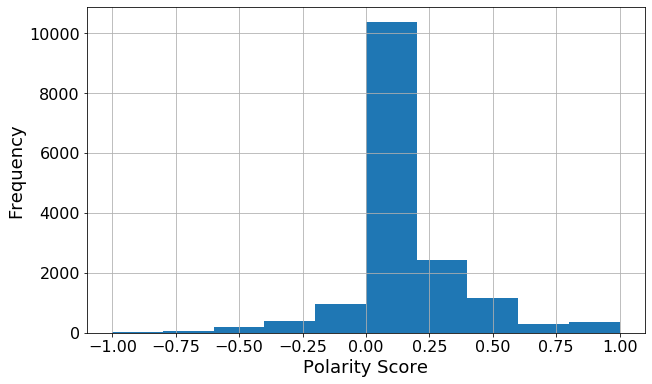

In [61]:
fig = plt.figure(figsize=(10, 6))
df['polarity'].hist()
plt.xlabel('Polarity Score', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
fig.savefig("./figures/polarity_hist.png")

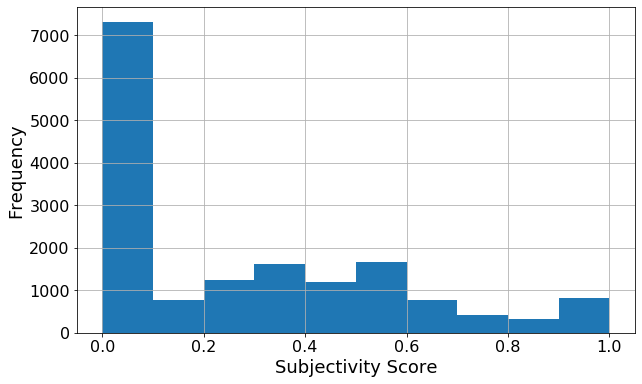

In [62]:
fig = plt.figure(figsize=(10, 6))
df['subjectivity'].hist()
plt.xlabel('Subjectivity Score', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
fig.savefig("./figures/subjectivity_hist.png")

## Inspection

In [63]:
# inspect the most negatively charged tweets
df.sort_values(by='polarity', ascending=True)[['text', 'polarity', 'subjectivity']].reset_index(drop=True).head(n=10)

,text,polarity,subjectivity
0,@AblemanAdam Terrible! Thank-you! And here in ...,-1.0,1.0
1,Pharmaceutical greed at its worst...\n\n#Pfize...,-1.0,1.0
2,"Day 4 w/#Moderna (shot 1)..\nugh, i'm miserabl...",-1.0,1.0
3,#Moderna side effects were terrible head aches...,-1.0,1.0
4,Outrageous that #Moderna #vaccine not approved...,-1.0,1.0
5,Death of 23 people's in #Norway after receivin...,-1.0,1.0
6,@ShamikaRavi @BharatBiotech Shocking #clinical...,-1.0,1.0
7,@gurpreetscheema @Milan_reports @BharatBiotech...,-1.0,1.0
8,#PfizerBioNTech #Vaccin #COVID19 #Moderna \nWH...,-1.0,0.6
9,Got my #Moderna Covid-19 vaccine dose 2 yester...,-1.0,0.8


In [64]:
# inspect the most positively charged tweets
df.sort_values(by='polarity', ascending=False)[['text', 'polarity', 'subjectivity']].reset_index(drop=True).head(n=10)

,text,polarity,subjectivity
0,Help us win this battle - Register to get your...,1.0,0.40
1,Questions in 🇧🇦 on whether the authorities agr...,1.0,0.30
2,This would be great news!\n#COVID19 #vaccines ...,1.0,0.75
3,"He took #COVAXIN, against which a lot of misin...",1.0,1.00
4,Great!\n#Covaxin \n#COVID19 https://t.co/KTVPE...,1.0,0.75
5,@ARanganathan72 Excellent work #Bharat 👏\n#Cov...,1.0,1.00
6,#Covid19 Excellent news 👏👏👏\nCongratulations @...,1.0,1.00
7,I'm thoroughly impressed by PM @narendramodi's...,1.0,1.00
8,Very happy to have been given the 1st dose of ...,1.0,1.00
9,"Just got vaccinated, and feel great about it! ...",1.0,0.75


In [65]:
# inspect the most subjective tweets (NOTE: subjectivity scale ranges from 0 to 1)
df.sort_values(by='subjectivity', ascending=True)[['text', 'polarity', 'subjectivity']].reset_index(drop=True).head(n=10)

,text,polarity,subjectivity
0,"2nd vaccine received today, thank you @OUHospi...",0.0,0.0
1,"article #compares #benefits of #Pfizer, #Moder...",0.0,0.0
2,#Thursday “Ok. I was watching @12News it says ...,0.0,0.0
3,Hey #Chicago..\n\nHeads up ! #COVID19 vaccine...,0.0,0.0
4,For everyone passing on the #Moderna and #Pfiz...,0.0,0.0
5,The complexities of international politics hit...,0.0,0.0
6,$MRNA 🇺🇸 #Moderna expects $18.4 billion in 202...,0.0,0.0
7,@CDCgov is lower back pain a side effect of th...,0.0,0.0
8,Also I got second dose #COVIDVaccine today #m...,0.0,0.0
9,Jean Marie will #Moderna-ize me https://t.co/4...,0.0,0.0


In [66]:
# inspect the most objective tweets
df.sort_values(by='subjectivity', ascending=False)[['text', 'polarity', 'subjectivity']].reset_index(drop=True).head(n=10)

,text,polarity,subjectivity
0,@Pfizer_France Here's manufacture @Pfizer_Fran...,0.625,1.0
1,@KyleClark @nexton9news Important #COVID19 #va...,0.400,1.0
2,Covid: India could play an important role in p...,0.400,1.0
3,Covid-19 Vaccine: Only 1 in 10 Take Jab After ...,0.000,1.0
4,Quote for today\nSayin' it as it is!\n#DollyPa...,0.500,1.0
5,Finally got my vaccine today it hurt like a bi...,0.000,1.0
6,#SputnikV in India is &gt; 10 and in #Pakistan...,0.000,1.0
7,Never have I seen a group of people so happy i...,0.800,1.0
8,@CBCNews Mayor of Nice in France asks health a...,0.600,1.0
9,I got the shot! #Moderna Relieved and happy to...,0.400,1.0


In [67]:
# let's inspect how many tweets there were with respect to time
timeline = df.groupby(['date']).count().reset_index()
timeline['count'] = timeline['text']
timeline = timeline[['date', 'count']]
fig = px.bar(timeline, x='date', y='count', labels={'date': 'Date', 'count': 'Tweet Count'})
fig.show()
# fig.write_image("./figures/tweet_freq_over_time.png")

# Time-Series Sentiment Analysis

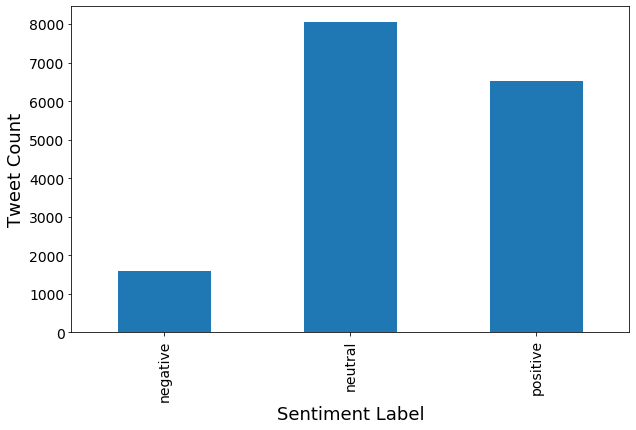

<Figure size 432x288 with 0 Axes>

In [68]:
# polarity values ranging from -1 to 1 are really useful for sentiment analysis
# but let's convert our data to 3 classes (negative, neutral, and positive) so that we can visualize it
criteria = [df['polarity'].between(-1, -0.01), df['polarity'].between(-0.01, 0.01), df['polarity'].between(0.01, 1)]
values = ['negative', 'neutral', 'positive']
df['sentiment'] = np.select(criteria, values, 0)

# plot sentiment counts
fig = plt.figure(figsize=(10, 6))
df['sentiment'].value_counts().sort_index().plot.bar()
plt.xlabel('Sentiment Label', fontsize=18)
plt.ylabel('Tweet Count', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
plt.tight_layout()
fig.savefig("./figures/sentiment_value_counts", bbox_inches='tight');

In [69]:
timeline = df.groupby(['date']).agg(np.nanmean).reset_index()
timeline['count'] = df.groupby(['date']).count().reset_index()['retweets']
timeline = timeline[['date', 'count', 'polarity', 'retweets', 'favorites', 'subjectivity']]
timeline["polarity"] = timeline["polarity"].astype(float)
timeline["subjectivity"] = timeline["subjectivity"].astype(float)
timeline

,date,count,polarity,retweets,favorites,subjectivity
0,2020-12-12,38,0.034952,0.631579,2.868421,0.227801
1,2020-12-13,52,0.055937,1.942308,7.500000,0.255696
2,2020-12-14,83,0.116874,4.698795,29.204819,0.267803
3,2020-12-15,87,0.094041,1.022989,7.333333,0.258078
4,2020-12-16,78,0.104020,1.000000,5.115385,0.248872
...,...,...,...,...,...,...
88,2021-03-10,465,0.098784,2.481720,9.987097,0.246851
89,2021-03-11,516,0.081946,2.232558,9.248062,0.253772
90,2021-03-12,467,0.108128,1.391863,8.509636,0.259496
91,2021-03-13,315,0.088139,3.161905,11.838095,0.290822


In [76]:
timeline.sort_values(by='polarity', ascending=False)

,date,count,polarity,retweets,favorites,subjectivity
12,2020-12-24,70,0.184387,3.657143,17.842857,0.310656
31,2021-01-12,52,0.182608,0.961538,6.961538,0.271700
19,2020-12-31,38,0.169196,1.184211,7.342105,0.282442
16,2020-12-28,26,0.165737,1.461538,4.769231,0.292030
33,2021-01-14,64,0.163502,0.843750,6.531250,0.268629
...,...,...,...,...,...,...
55,2021-02-05,40,0.058663,0.325000,9.000000,0.195590
1,2020-12-13,52,0.055937,1.942308,7.500000,0.255696
35,2021-01-16,82,0.039450,9.670732,17.024390,0.262114
0,2020-12-12,38,0.034952,0.631579,2.868421,0.227801


In [78]:
df[df['date'].astype(str) == '2021-01-12'][['user_location', 'date', 'text', 'hashtags', 'polarity', 'subjectivity', 'sentiment']]

,user_location,date,text,hashtags,polarity,subjectivity,sentiment
2416,Northern Ireland,2021-01-12,Delighted to receive my second vaccine today 👏...,"['PfizerBioNTech', 'COVID19Vaccine']",0.350000,0.350000,positive
2531,"Nottingham, England",2021-01-12,Had my COVID-19 vaccine on Friday 💉 and experi...,"['COVIDVaccination', 'PfizerBioNTech']",0.650000,0.700000,positive
2952,Ragbag Of Reviews And Insights,2021-01-12,#EU Plans To Purchase 300-million More #Covid1...,"['EU', 'Covid19', 'covidvaccines', 'Pfizer']",0.500000,0.500000,positive
3121,"Corleone, Sicilia",2021-01-12,Just had my first #COVIDVaccination #COVID19 I...,"['COVIDVaccination', 'COVID19', 'PfizerVaccine...",0.250000,0.333333,positive
3124,"London, UK",2021-01-12,Getting vaccinated today. ☺️ #PfizerBioNTech,['PfizerBioNTech'],0.000000,0.000000,neutral
3128,"Vienna, Dublin, & Cyberspace",2021-01-12,@AvilaLipsett @jessica_anhold Woefully behind ...,"['Israel', 'PfizerBioNTech']",-0.103571,0.572619,negative
3131,UK,2021-01-12,#Covid-19 vaccines are from \n\n#PfizerBioNTec...,"['Covid', 'PfizerBioNTech', 'Oxford', 'AstraZe...",0.000000,0.000000,neutral
3132,"South West, England",2021-01-12,Had my first dose of #PfizerBioNTech vaccine t...,['PfizerBioNTech'],0.470000,0.624444,positive
3133,"Southampton, England",2021-01-12,There isn't enough words to say how grateful I...,"['COVID19Vaccine', 'PfizerBioNTech']",0.125000,0.416667,positive
3134,Belgium,2021-01-12,Discover today's front pages of the #BelgianPr...,"['BelgianPress', 'MbayeLeye', 'Standard', 'var...",0.000000,0.000000,neutral


In [70]:
# Plot tweets over time, color-coded by average polarity score
fig = px.bar(timeline, x='date', y='count', color='polarity')
fig.show()

In [165]:
# # Plot tweets over time, color-coded by average subjectivity score
fig = px.bar(timeline, x='date', y='count', color='subjectivity')
fig.show()

# Filter by Vaccy

In [109]:
all_vax = ['covaxin', 'sinopharm', 'sinovac', 'moderna', 'pfizer', 'biontech', 'oxford', 'astrazeneca', 'sputnik']

# Function to filter the data to a single vaccine and plot the timeline
# Note: a lot of the tweets seem to contain hashtags for multiple vaccines even though they are specifically referring to one vaccine-- not very helpful!
def filter_by_vaccy(df, vax):
    df_filt = pd.DataFrame()
    for v in vax:
        df_filt = df_filt.append(df[df['text'].str.lower().str.contains(v)])
    other_vax = list(set(all_vax)-set(vax))
    for o in other_vax:
        df_filt = df_filt[~df_filt['text'].str.lower().str.contains(o)]
#     df_filt = df_filt.drop_duplicates()
    timeline = df_filt.groupby(['date']).agg(np.nanmean).reset_index()
    timeline['count'] = df_filt.groupby(['date']).count().reset_index()['retweets']
    timeline = timeline[['date', 'count', 'polarity', 'retweets', 'favorites', 'subjectivity']]
    timeline["polarity"] = timeline["polarity"].astype(float)
    timeline["subjectivity"] = timeline["subjectivity"].astype(float)
    return df_filt, timeline

In [110]:
pfizy_df, pfizy_timeline = filter_by_vaccy(df, ['pfizer', 'biontech'])
print(pfizy_df.shape)
fig = px.bar(pfizy_timeline, x='date', y='count', color='polarity')
fig.show()

(5454, 19)


In [111]:
moderna_df, moderna_timeline = filter_by_vaccy(df, ['moderna'])
print(moderna_df.shape)
fig = px.bar(moderna_timeline, x='date', y='count', color='polarity')
fig.show()

(2604, 19)


In [112]:
astra_df, astra_timeline = filter_by_vaccy(df, ['astrazeneca'])
astra_df.sort_values(by='polarity', ascending=True).reset_index(drop=True).head(n=20)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,polarity,subjectivity,sentiment,words
0,Ricarda Milstein,Hamburg - Berlin,Health Economist @unihh/@hche_uhh. Passion for...,2014-09-24 20:22:30,388,387,3863,False,2021-02-17,The @tagesspiegel reports that only 2% of 🇩🇪 w...,['AstraZeneca'],Twitter Web App,8,10,False,-0.350000,0.833333,negative,"[The, tagesspiegel, reports, that, only, 2, of..."
1,Bart Kulpa,"London, UK",Globally-minded person working for an internat...,2014-03-14 15:46:47,3951,3938,40651,False,2021-03-05,"In AstraZeneca spat, EU fights hard for a vacc...","['Europe', 'EU']",Twitter for Android,1,0,False,-0.291667,0.541667,negative,"[In, AstraZeneca, spat, EU, fights, hard, for,..."
2,Anurag Sinha,"Ottawa, Canada",International Affairs; Itinerant ✈️🇲🇹 ✈️ 🇬🇧 ✈️...,2008-11-04 14:47:14,360,3314,5546,False,2021-02-10,@szarabi Not sure what you mean by India-made....,"['AstraZeneca', 'Canada']",Twitter for iPhone,0,2,False,-0.281250,0.788194,negative,"[szarabi, Not, sure, what, you, mean, by, Indi..."
3,EurAsian Times,Global,EurAsian Times provides Latest International N...,2014-11-18 09:13:11,3017,132,3,False,2021-03-03,#Malaysia granted conditional approval for the...,"['Malaysia', 'UK', 'AstraZeneca']",Twitter Web App,1,1,False,-0.200000,0.400000,negative,"[Malaysia, granted, conditional, approval, for..."
4,Michael Wynne,Bahrain,Views and opinions are my own. You are entitle...,2011-02-09 00:47:27,192,725,3668,False,2021-03-04,@caulmick Independent... me hole... Seriously ...,['AstraZeneca'],Twitter for iPhone,1,1,False,-0.166667,0.395833,negative,"[caulmick, Independent, me, hole, Seriously, t..."
5,India Post,"Fremont, CA, USA",Refresh yourself every morning with India Post...,2009-03-24 20:03:31,628,699,15,False,2021-02-08,AstraZeneca's vaccine less ... - https://t.co/...,"['IndiaPostUSA', 'AnthonyFauci']",IndiaPost,0,0,False,-0.166667,0.066667,negative,"[AstraZeneca, s, vaccine, less, https, t, co, ..."
6,Ramon Denz,Gaza,Free Palestine - Friend of Muslims - ANTI Raci...,2020-07-08 10:09:23,263,502,10990,False,2021-02-08,#AstraZeneca proofs to be NOT functioning at a...,"['AstraZeneca', 'Corona']",Twitter Web App,0,0,False,-0.150000,0.450000,negative,"[AstraZeneca, proofs, to, be, NOT, functioning..."
7,Dr George Christos,"Perth, Western Australia",theoretical physicist/mathematician/neuroscien...,2015-05-31 11:15:30,861,89,7199,False,2021-03-05,i still cannot see what we are using #AstraZen...,"['AstraZeneca', 'vaccine', 'efficacy']",Twitter Web App,0,1,False,-0.150000,0.200000,negative,"[i, still, cannot, see, what, we, are, using, ..."
8,🕷Financial Bear 3.5%,#KeepFightingMichael,Pro the EU for the opportunities it offers cit...,2012-03-10 08:03:36,1677,899,29431,False,2020-12-30,#AstraZeneca vaccine is going to have a commun...,['AstraZeneca'],Twitter Web App,1,0,False,-0.125000,0.375000,negative,"[AstraZeneca, vaccine, is, going, to, have, a,..."
9,Rose Webster,Canada,I question everything. Fighter for the underdo...,2011-05-28 03:43:08,949,966,65647,False,2021-01-29,@Reuters_Health @AstraZeneca's #COVID19 #vacci...,"['COVID19', 'vaccine']",Twitter Web App,3,1,False,-0.100000,0.400000,negative,"[Reuters_Health, AstraZeneca, s, COVID19, vacc..."


In [113]:
covaxin_df, covaxin_timeline = filter_by_vaccy(df, ['covaxin'])
covaxin_df.sort_values(by='polarity', ascending=True).reset_index(drop=True).head(n=20)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,polarity,subjectivity,sentiment,words
0,Prasenjit Bhakat,"Jhargram,W Bengal,India",Past President (2011-12): Rotary Jhargram Gree...,2009-08-31 02:14:30,390,1658,5071,False,2021-03-03,@ShamikaRavi @BharatBiotech Shocking #clinical...,"['clinicaltrials', 'COVID19Vaccine', 'Covaxin']",Twitter Web App,0,0,False,-1.000000,1.000000,negative,"[ShamikaRavi, BharatBiotech, Shocking, clinica..."
1,Prasenjit Bhakat,"Jhargram,W Bengal,India",Past President (2011-12): Rotary Jhargram Gree...,2009-08-31 02:14:30,390,1658,5071,False,2021-03-03,@gurpreetscheema @Milan_reports @BharatBiotech...,"['clinicaltrials', 'COVID19Vaccine']",Twitter Web App,0,0,False,-1.000000,1.000000,negative,"[gurpreetscheema, Milan_reports, BharatBiotech..."
2,Balaji,Bengaluru,"Classical Liberal. Wry wit, that usually fails.",2008-08-07 17:03:25,487,148,5278,False,2021-03-01,Prime Moron.\n\nTerrible advertisement for res...,['Covaxin'],Twitter for iPhone,0,1,False,-0.900000,1.000000,negative,"[Prime, Moron, Terrible, advertisement, for, r..."
3,Dilip Jain | दिलीप जैन 🇮🇳,"Bengaluru, India",Entrepreneur ● Love Cooking ● Blessed To Be Fo...,2010-05-09 18:31:09,13869,410,80561,False,2021-03-01,"@tinucherian @narendramodi Hello hate machine,...",['COVAXIN'],Twitter for Android,5,133,False,-0.800000,0.900000,negative,"[tinucherian, narendramodi, Hello, hate, machi..."
4,Balaji Ganesan,"Bengaluru, India",Engineer @IBMResearch. Interested in Knowledge...,2010-06-19 08:20:41,373,370,868,False,2021-03-01,"Nature doesn’t play dice.\n\nIn India, Govt do...","['covishield', 'Covaxin']",Twitter for iPhone,0,2,False,-0.700000,0.666667,negative,"[Nature, doesn, t, play, dice, In, India, Govt..."
5,#SETTARGETS 🎯,"London, England","⏳ It's a marathon, not a sprint. 💎 Do your own...",2021-01-04 12:59:10,57,157,731,False,2021-03-01,WHERE THE FUCK IS @CNN NOW! Report on this new...,['COVAXIN'],Twitter for iPhone,0,5,False,-0.650000,0.700000,negative,"[WHERE, THE, FUCK, IS, CNN, NOW, Report, on, t..."
6,NAV BHARAT,"New Delhi, India",जाति 👉 प्रातः- शूद्र || फिर ब्राह्मण || फिर वै...,2014-01-05 15:15:18,292,750,11592,False,2021-03-04,Request @theJagmeetSingh to have one made in i...,"['Covaxin', 'CoronaVaccine']",Twitter for iPhone,1,1,False,-0.600000,0.800000,negative,"[Request, theJagmeetSingh, to, have, one, made..."
7,ब्रह्मराक्षस👹,Gorakhpur & New Delhi,"∣ ɴᴀᴛɪᴏɴ ғɪʀsᴛ 🇮🇳 |\n॥एकोऽहम् द्वितीयो नास्ति,...",2018-09-24 15:09:08,1065,1015,1831,False,2021-03-01,When you are afraid of taking injection bt the...,"['Covaxin', 'CoronaVaccine']",Twitter for Android,0,2,False,-0.600000,0.900000,negative,"[When, you, are, afraid, of, taking, injection..."
8,MaryRobotic,"California, United States","Mask-loving, Trump-hating liberal\nopposed to ...",2019-03-25 17:58:43,79,1,9461,False,2021-03-02,@Yalpanam10 @bsindia Please send all of the #C...,['Covaxin'],Twitter Web App,0,2,False,-0.600000,1.000000,negative,"[Yalpanam10, bsindia, Please, send, all, of, t..."
9,Jayraj Patil,United States of Maharashtra,#Engineer #Banker #BusinessAnalyst #Analytical...,2019-09-15 12:18:11,35,1187,11080,False,2021-03-06,@JhaSanjay Agreed. Even I was skeptical about ...,['Covaxin'],Twitter for Android,1,2,False,-0.500000,0.700000,negative,"[JhaSanjay, Agreed, Even, I, was, skeptical, a..."


# Wordclouds

In [114]:
from wordcloud import WordCloud, ImageColorGenerator
import wordninja
from spellchecker import SpellChecker
from collections import Counter
import nltk
import math
import random
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english'))  
stop_words.add("amp")

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sejaldua/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sejaldua/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Simple

(-0.5, 999.5, 499.5, -0.5)

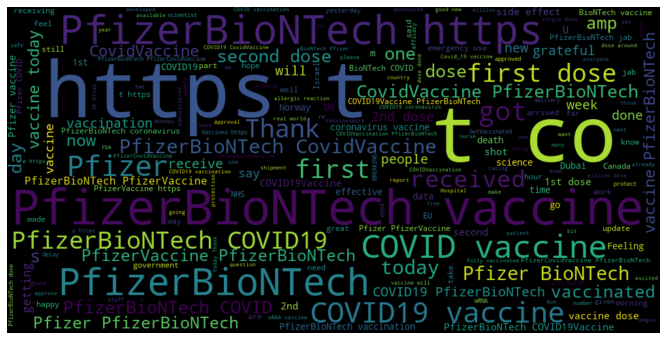

In [115]:
tweet_df = pfizy_df
words = ' '.join([word for word in tweet_df['text']])
word_cloud = WordCloud(width=1000, height=500, random_state=20, max_font_size=120).generate(words)

fig, ax = plt.subplots(figsize=(12,6))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

## Advanced

In [121]:
def flatten_list(l):
    return [x for y in l for x in y]

def is_acceptable(word: str):
    return word not in stop_words and len(word) > 2

# Color coding our wordclouds 
def red_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(0, 100%, {random.randint(25, 75)}%)" 

def green_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl({random.randint(90, 150)}, 100%, 30%)" 

def yellow_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(42, 100%, {random.randint(25, 50)}%)" 

# Reusable function to generate word clouds 
def generate_word_clouds(neg_doc, neu_doc, pos_doc):
    # Display the generated image:
    fig, axes = plt.subplots(1,3, figsize=(20,10))
    
    wordcloud_neg = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(neg_doc))
    axes[0].imshow(wordcloud_neg.recolor(color_func=red_color_func, random_state=3), interpolation='bilinear')
    axes[0].set_title("Negative Words")
    axes[0].axis("off")

    wordcloud_neu = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(neu_doc))
    axes[1].imshow(wordcloud_neu.recolor(color_func=yellow_color_func, random_state=3), interpolation='bilinear')
    axes[1].set_title("Neutral Words")
    axes[1].axis("off")

    wordcloud_pos = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(pos_doc))
    axes[2].imshow(wordcloud_pos.recolor(color_func=green_color_func, random_state=3), interpolation='bilinear')
    axes[2].set_title("Positive Words")
    axes[2].axis("off")

    plt.tight_layout()
#     plt.show();
    return fig

def get_top_percent_words(doc, percent):
    # Returns a list of "top-n" most frequent words in a list 
    top_n = int(percent * len(set(doc)))
    counter = Counter(doc).most_common(top_n)
    top_n_words = [x[0] for x in counter]
    # print(top_n_words)
    return top_n_words
    
def clean_document(doc):
    spell = SpellChecker()
    lemmatizer = WordNetLemmatizer()
    
    # Lemmatize words (needed for calculating frequencies correctly )
    doc = [lemmatizer.lemmatize(x) for x in doc]
    
    # Get the top 10% of all words. This may include "misspelled" words 
    top_n_words = get_top_percent_words(doc, 0.1)

    # Get a list of misspelled words 
    misspelled = spell.unknown(doc)
    
    # Accept the correctly spelled words and top_n words 
    clean_words = [x for x in doc if x not in misspelled or x in top_n_words]
    
    # Try to split the misspelled words to generate good words (ex. "lifeisstrange" -> ["life", "is", "strange"])
    words_to_split = [x for x in doc if x in misspelled and x not in top_n_words]
    split_words = flatten_list([wordninja.split(x) for x in words_to_split])
    
    # Some splits may be nonsensical, so reject them ("llouis" -> ['ll', 'ou', "is"])
    clean_words.extend(spell.known(split_words))
    
    return clean_words

def get_log_likelihood(doc1, doc2):    
    doc1_counts = Counter(doc1)
    doc1_freq = {
        x: doc1_counts[x]/len(doc1)
        for x in doc1_counts
    }
    
    doc2_counts = Counter(doc2)
    doc2_freq = {
        x: doc2_counts[x]/len(doc2)
        for x in doc2_counts
    }
    
    doc_ratios = {
        # 1 is added to prevent division by 0
        x: math.log((doc1_freq[x] +1 )/(doc2_freq[x]+1))
        for x in doc1_freq if x in doc2_freq
    }
    
    top_ratios = Counter(doc_ratios).most_common()
    top_percent = int(0.1 * len(top_ratios))
    return top_ratios[:top_percent]

# Function to generate a document based on likelihood values for words 
def get_scaled_list(log_list):
    counts = [int(x[1]*100000) for x in log_list]
    words = [x[0] for x in log_list]
    cloud = []
    for i, word in enumerate(words):
        cloud.extend([word]*counts[i])
    # Shuffle to make it more "real"
    random.shuffle(cloud)
    return cloud

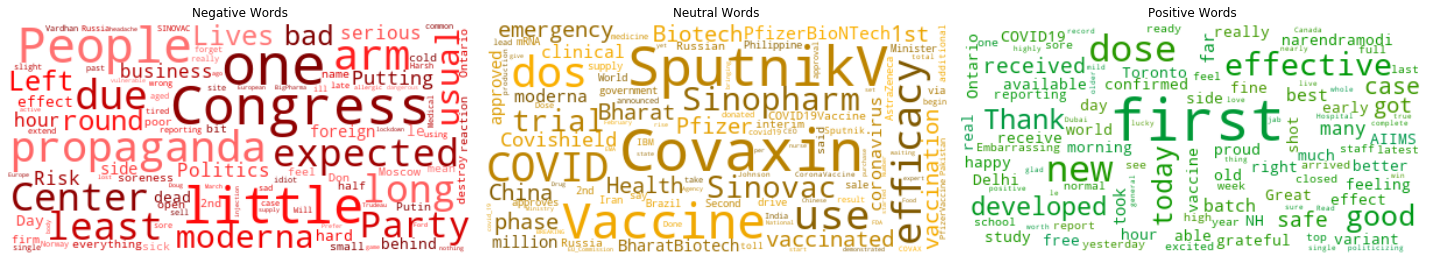

In [122]:
def get_smart_clouds(df):

    neg_doc = flatten_list(df[df['sentiment']=='negative']['words'])
    neg_doc = [x for x in neg_doc if is_acceptable(x)]

    pos_doc = flatten_list(df[df['sentiment']=='positive']['words'])
    pos_doc = [x for x in pos_doc if is_acceptable(x)]

    neu_doc = flatten_list(df[df['sentiment']=='neutral']['words'])
    neu_doc = [x for x in neu_doc if is_acceptable(x)]

    # Clean all the documents
    neg_doc_clean = clean_document(neg_doc)
    neu_doc_clean = clean_document(neu_doc)
    pos_doc_clean = clean_document(pos_doc)

    # Combine classes B and C to compare against A (ex. "positive" vs "non-positive")
    top_neg_words = get_log_likelihood(neg_doc_clean, flatten_list([pos_doc_clean, neu_doc_clean]))
    top_neu_words = get_log_likelihood(neu_doc_clean, flatten_list([pos_doc_clean, neg_doc_clean]))
    top_pos_words = get_log_likelihood(pos_doc_clean, flatten_list([neu_doc_clean, neg_doc_clean]))

    # Generate syntetic a corpus using our loglikelihood values 
    neg_doc_final = get_scaled_list(top_neg_words)
    neu_doc_final = get_scaled_list(top_neu_words)
    pos_doc_final = get_scaled_list(top_pos_words)

    # Visualise our synthetic corpus
    fig = generate_word_clouds(neg_doc_final, neu_doc_final, pos_doc_final)
    return fig

# Convert string to a list of words
wordcloud_df = df
wordcloud_df['words'] = wordcloud_df.text.apply(lambda x:re.findall(r'\w+', x ))
get_smart_clouds(wordcloud_df).savefig("sentiment_wordclouds.png", bbox_inches="tight")

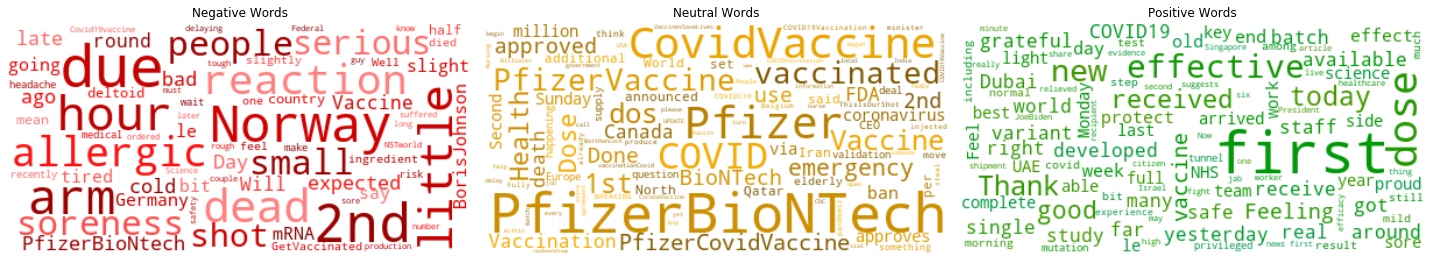

In [123]:
wordcloud_df = pfizy_df
wordcloud_df['words'] = wordcloud_df.text.apply(lambda x:re.findall(r'\w+', x ))
get_smart_clouds(wordcloud_df).savefig("pfizy_sentiment_wordclouds.png", bbox_inches="tight")

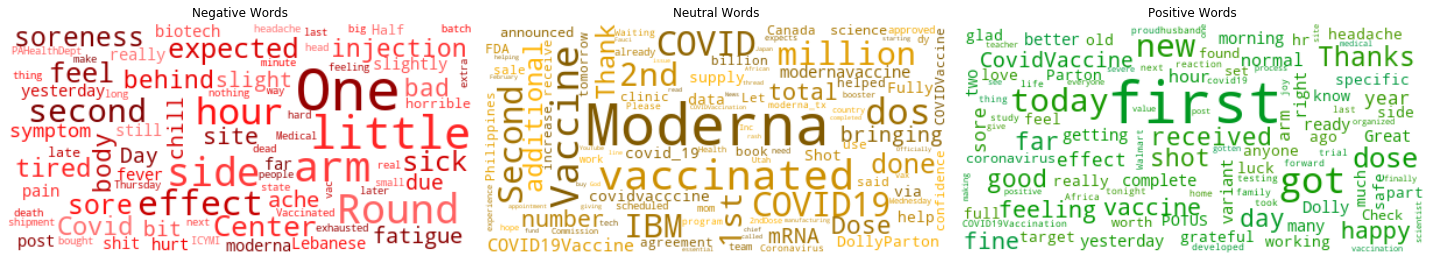

In [124]:
wordcloud_df = moderna_df
wordcloud_df['words'] = wordcloud_df.text.apply(lambda x:re.findall(r'\w+', x ))
get_smart_clouds(wordcloud_df).savefig("moderna_sentiment_wordclouds.png", bbox_inches="tight")

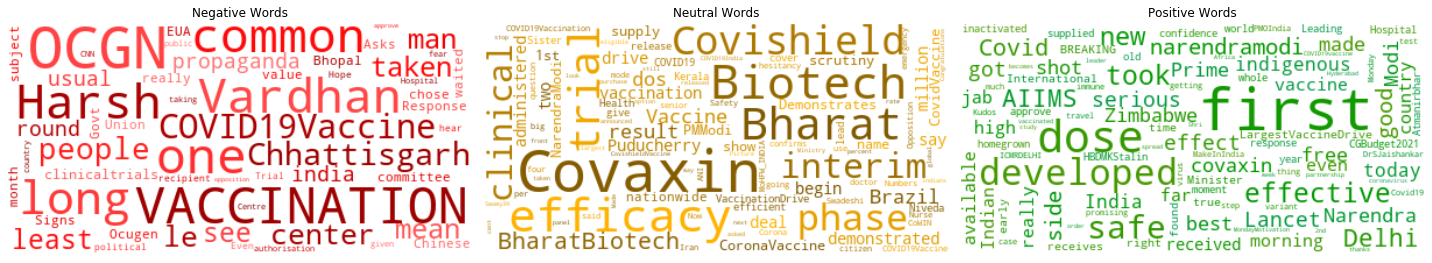

In [125]:
wordcloud_df = covaxin_df
wordcloud_df['words'] = wordcloud_df.text.apply(lambda x:re.findall(r'\w+', x ))
get_smart_clouds(wordcloud_df).savefig("covaxin_sentiment_wordclouds.png", bbox_inches="tight")

# Extension Ideas

* Use the  `tweepy` [API](https://docs.tweepy.org/en/latest/) to get tweets about the Johnson & Johnson Vaccine, and apply sentiment analysis onto them.
* Which hashtags are people using? Is the use of hashtags correlated with higher like counts and/or retweet counts?
* Analyze the faction of the tweets that include URLs. Do tweets with URLs have primarily neutral sentiments?
* What are verified Twitter users saying about the COVID-19 vaccine?
* What are people saying with respect to side effects? Which vaccine has the worst side effects?
* Correlate the COVID-19 World Vaccination Progress dataset with this sentiment analysis to monitor how attitudes are changing towards the vaccine as the rollout continues.
